# Dynap-SE2 DC Excitation


## Imports

In [1]:
from rockpool.nn.combinators import Sequential
from rockpool.timeseries import TSEvent, TSContinuous

# Utils
import numpy as np
import time

# - Plotting and config
import matplotlib.pyplot as plt

# Dynap-SE2 imports
from rockpool.devices.dynapse import (
    mapper,
    config_from_specification,
    find_dynapse_boards,
    DynapseSamna,
    DynapSim,
)


# %matplotlib inline
plt.rcParams["figure.figsize"] = [5.6, 2.8]
plt.rcParams["figure.dpi"] = 1200
plt.rcParams["font.size"] = 12


/Users/ugurcancakal/rockpool/lib/python3.10/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


## Step 0 : No input, just DC

Just prove that the interfacing works


## Step 1 : Build a Network


In [2]:
net = Sequential(DynapSim(20, Idc=2e-8))

## Step 2 : Simulate


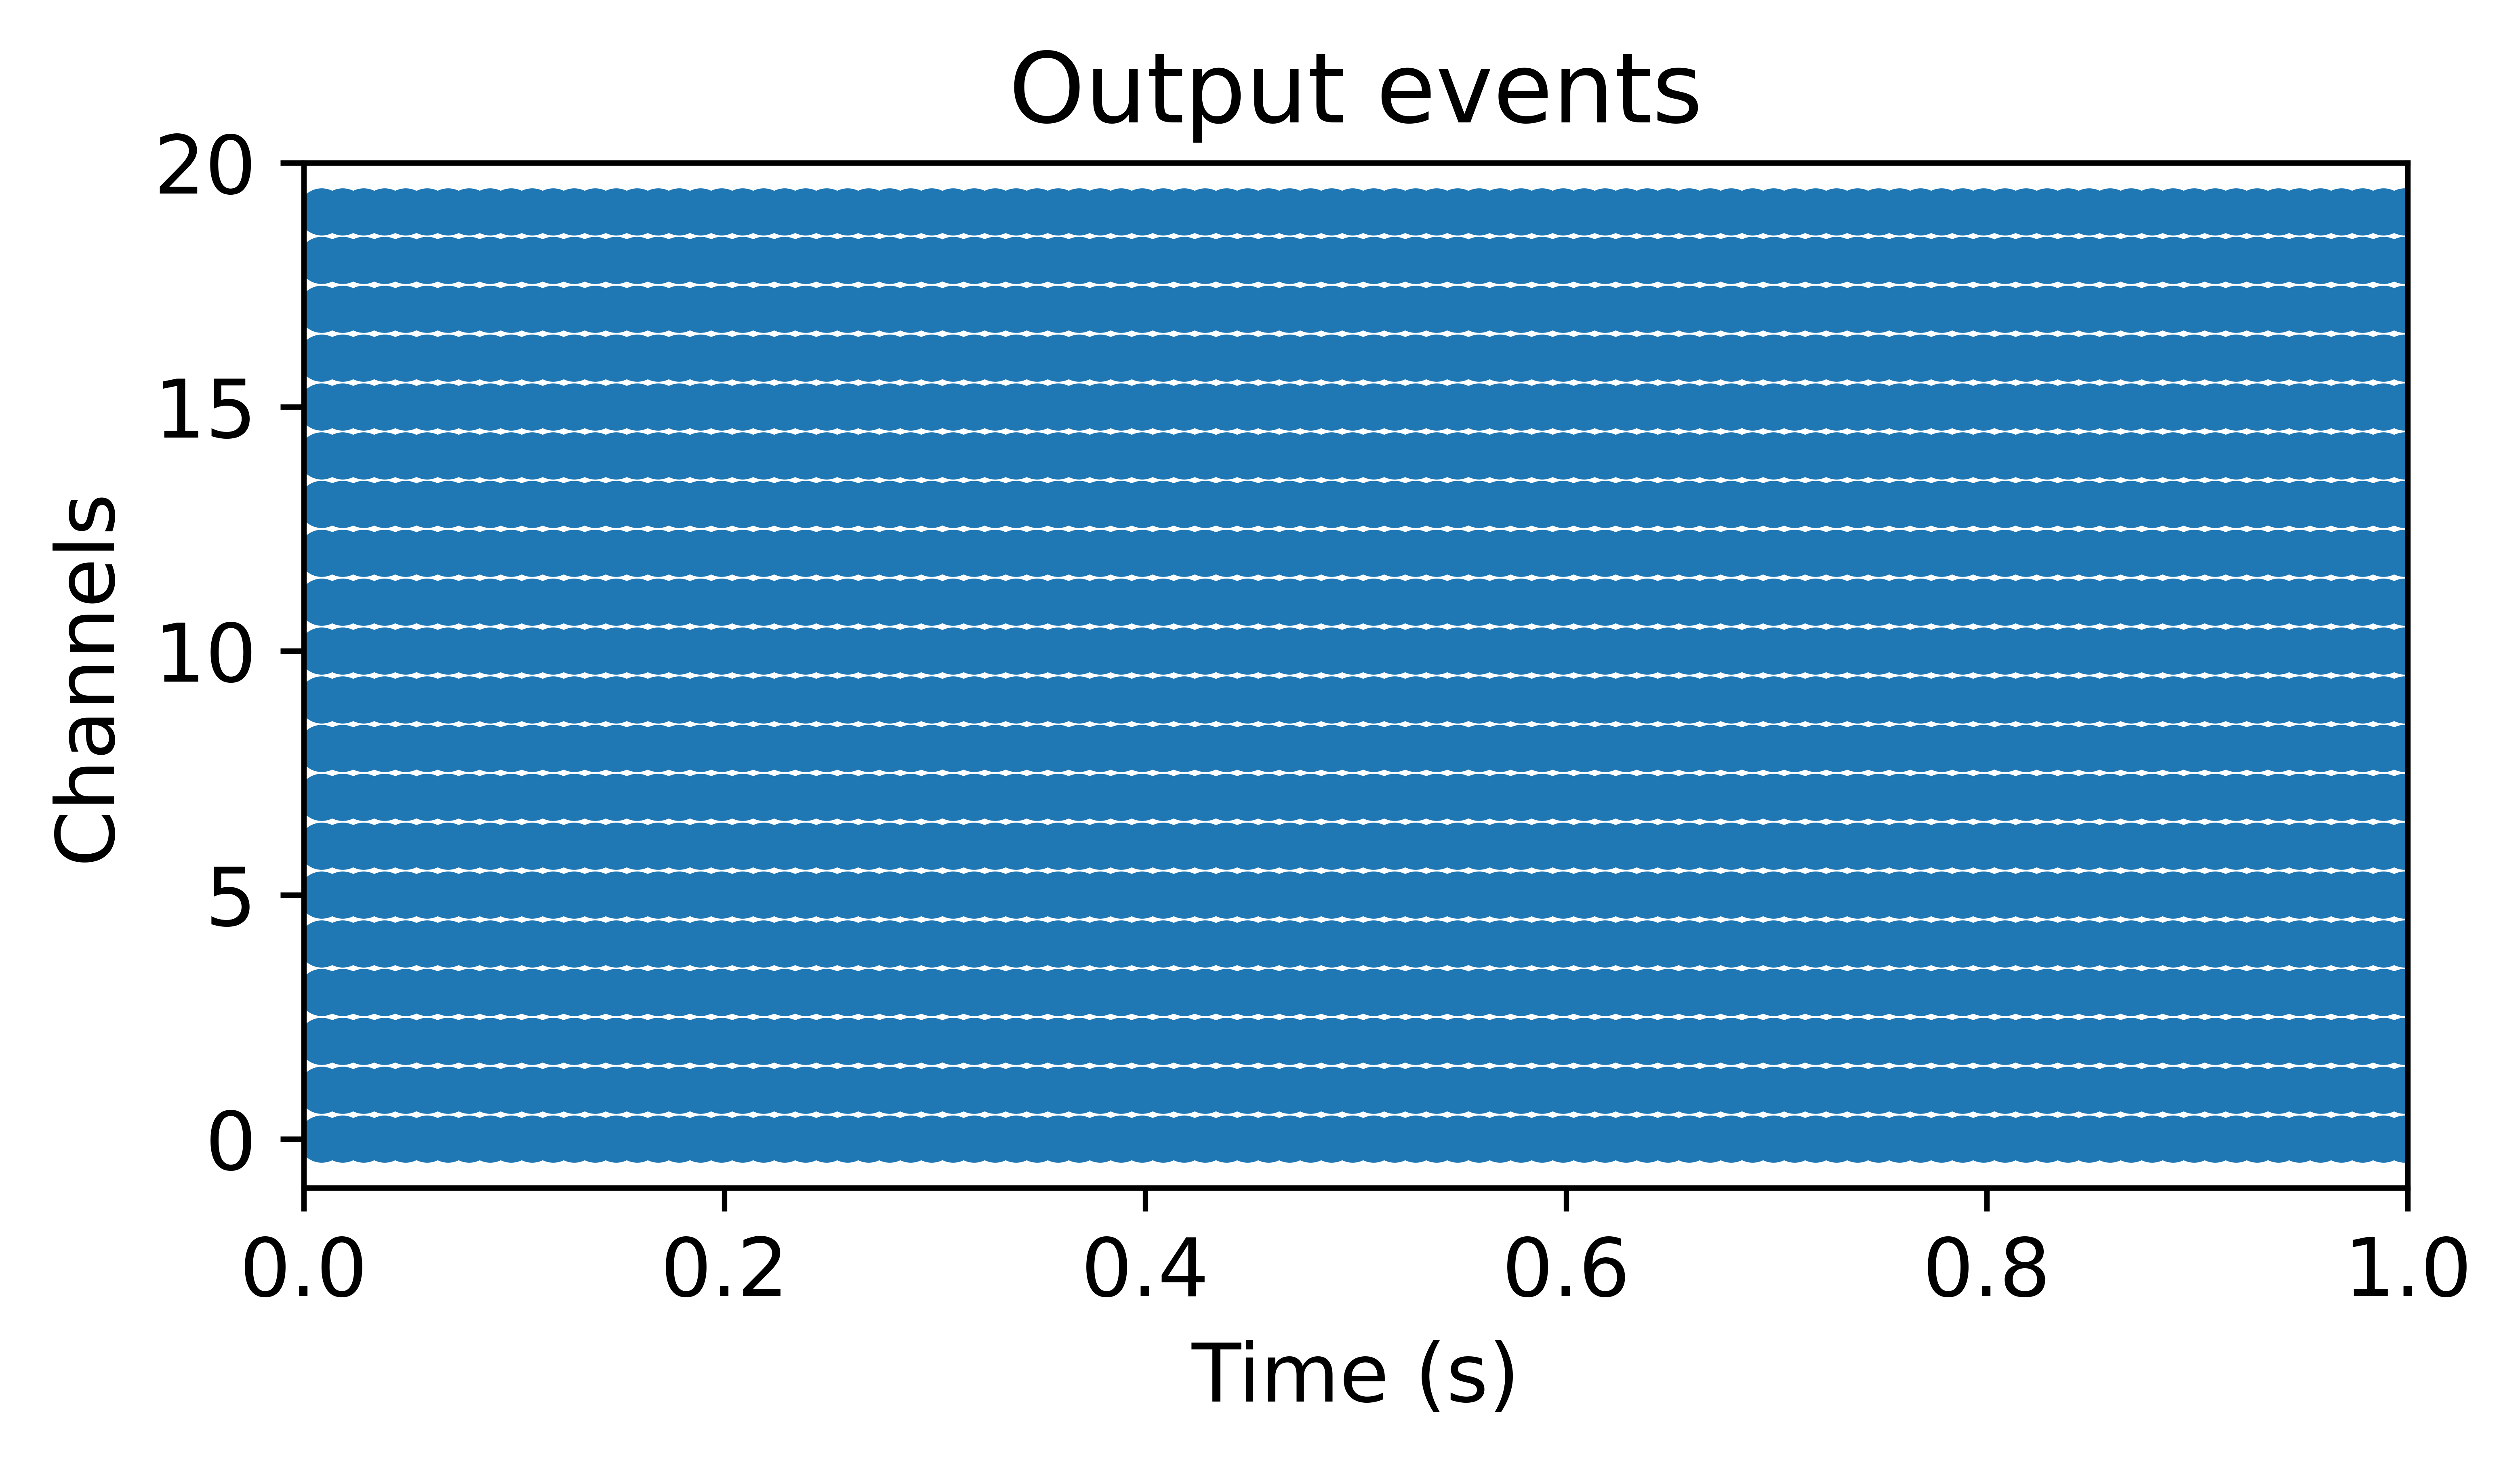

In [3]:
net.reset_state()
dt = 1e-3
out, state, rec = net(np.zeros(1000))
TSEvent.from_raster(out[0], dt, name = 'Output events').plot();

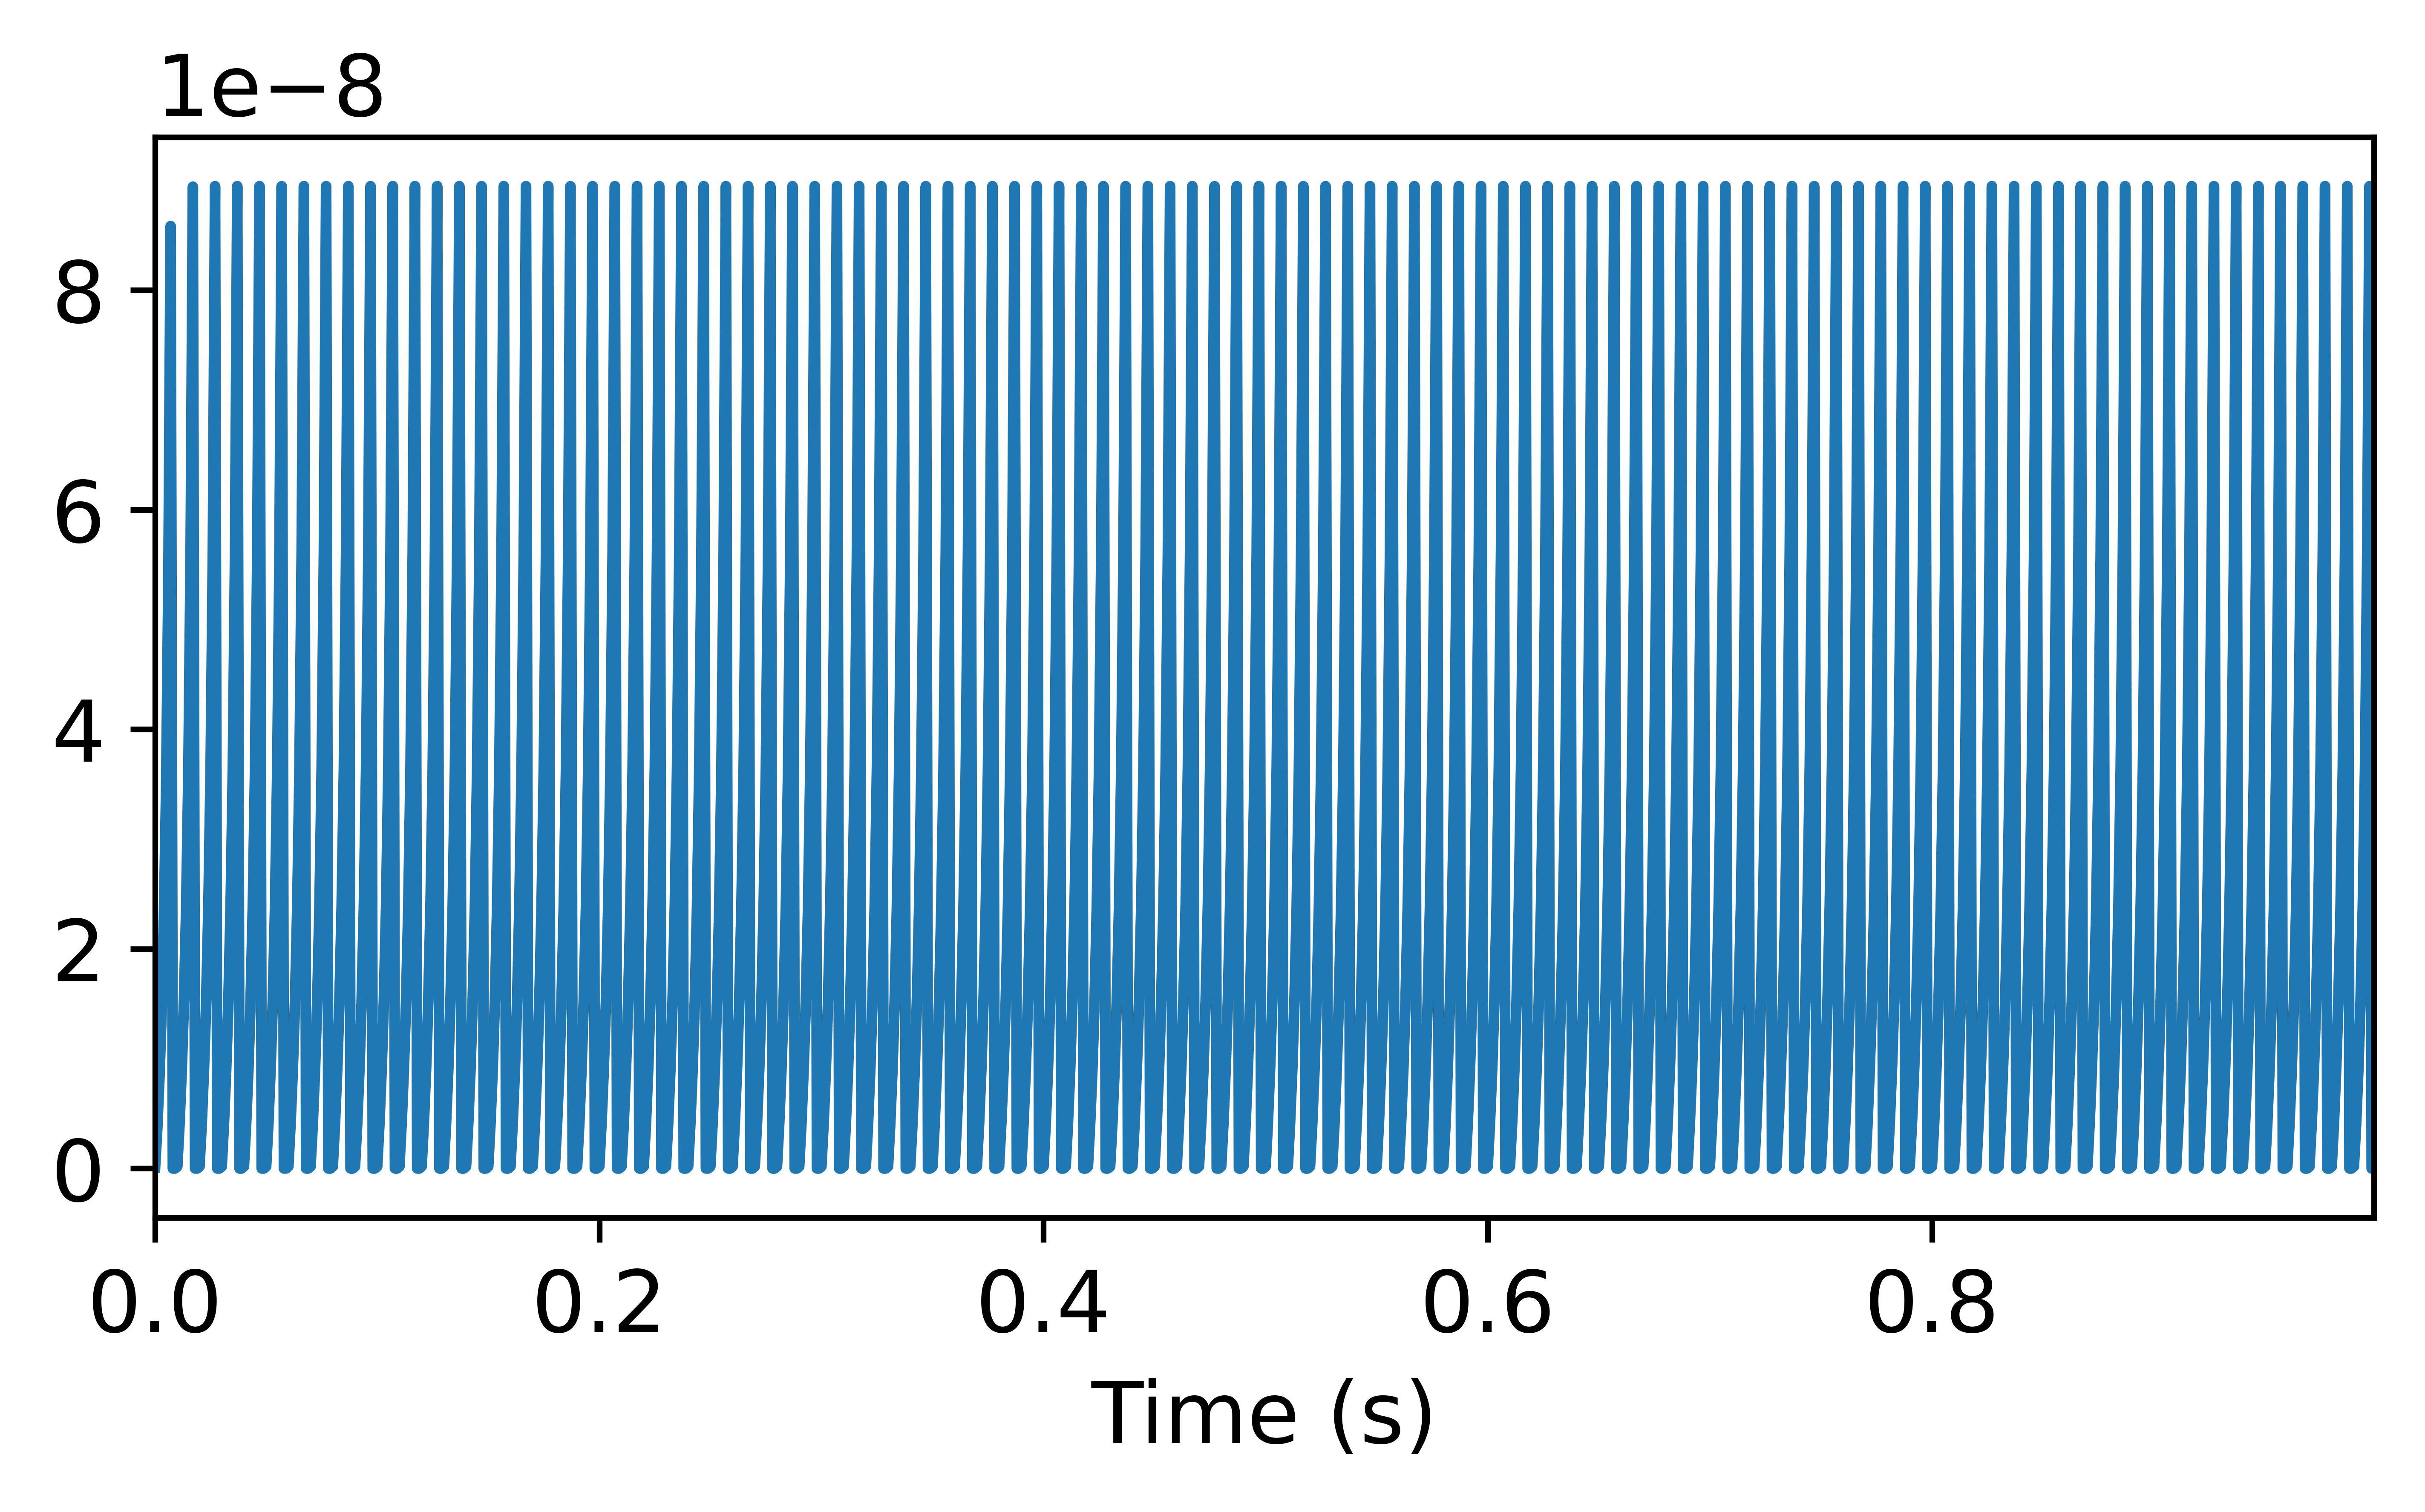

In [4]:
TSContinuous.from_clocked(rec['0_DynapSim']['imem'][0,:,0], dt=dt).plot()

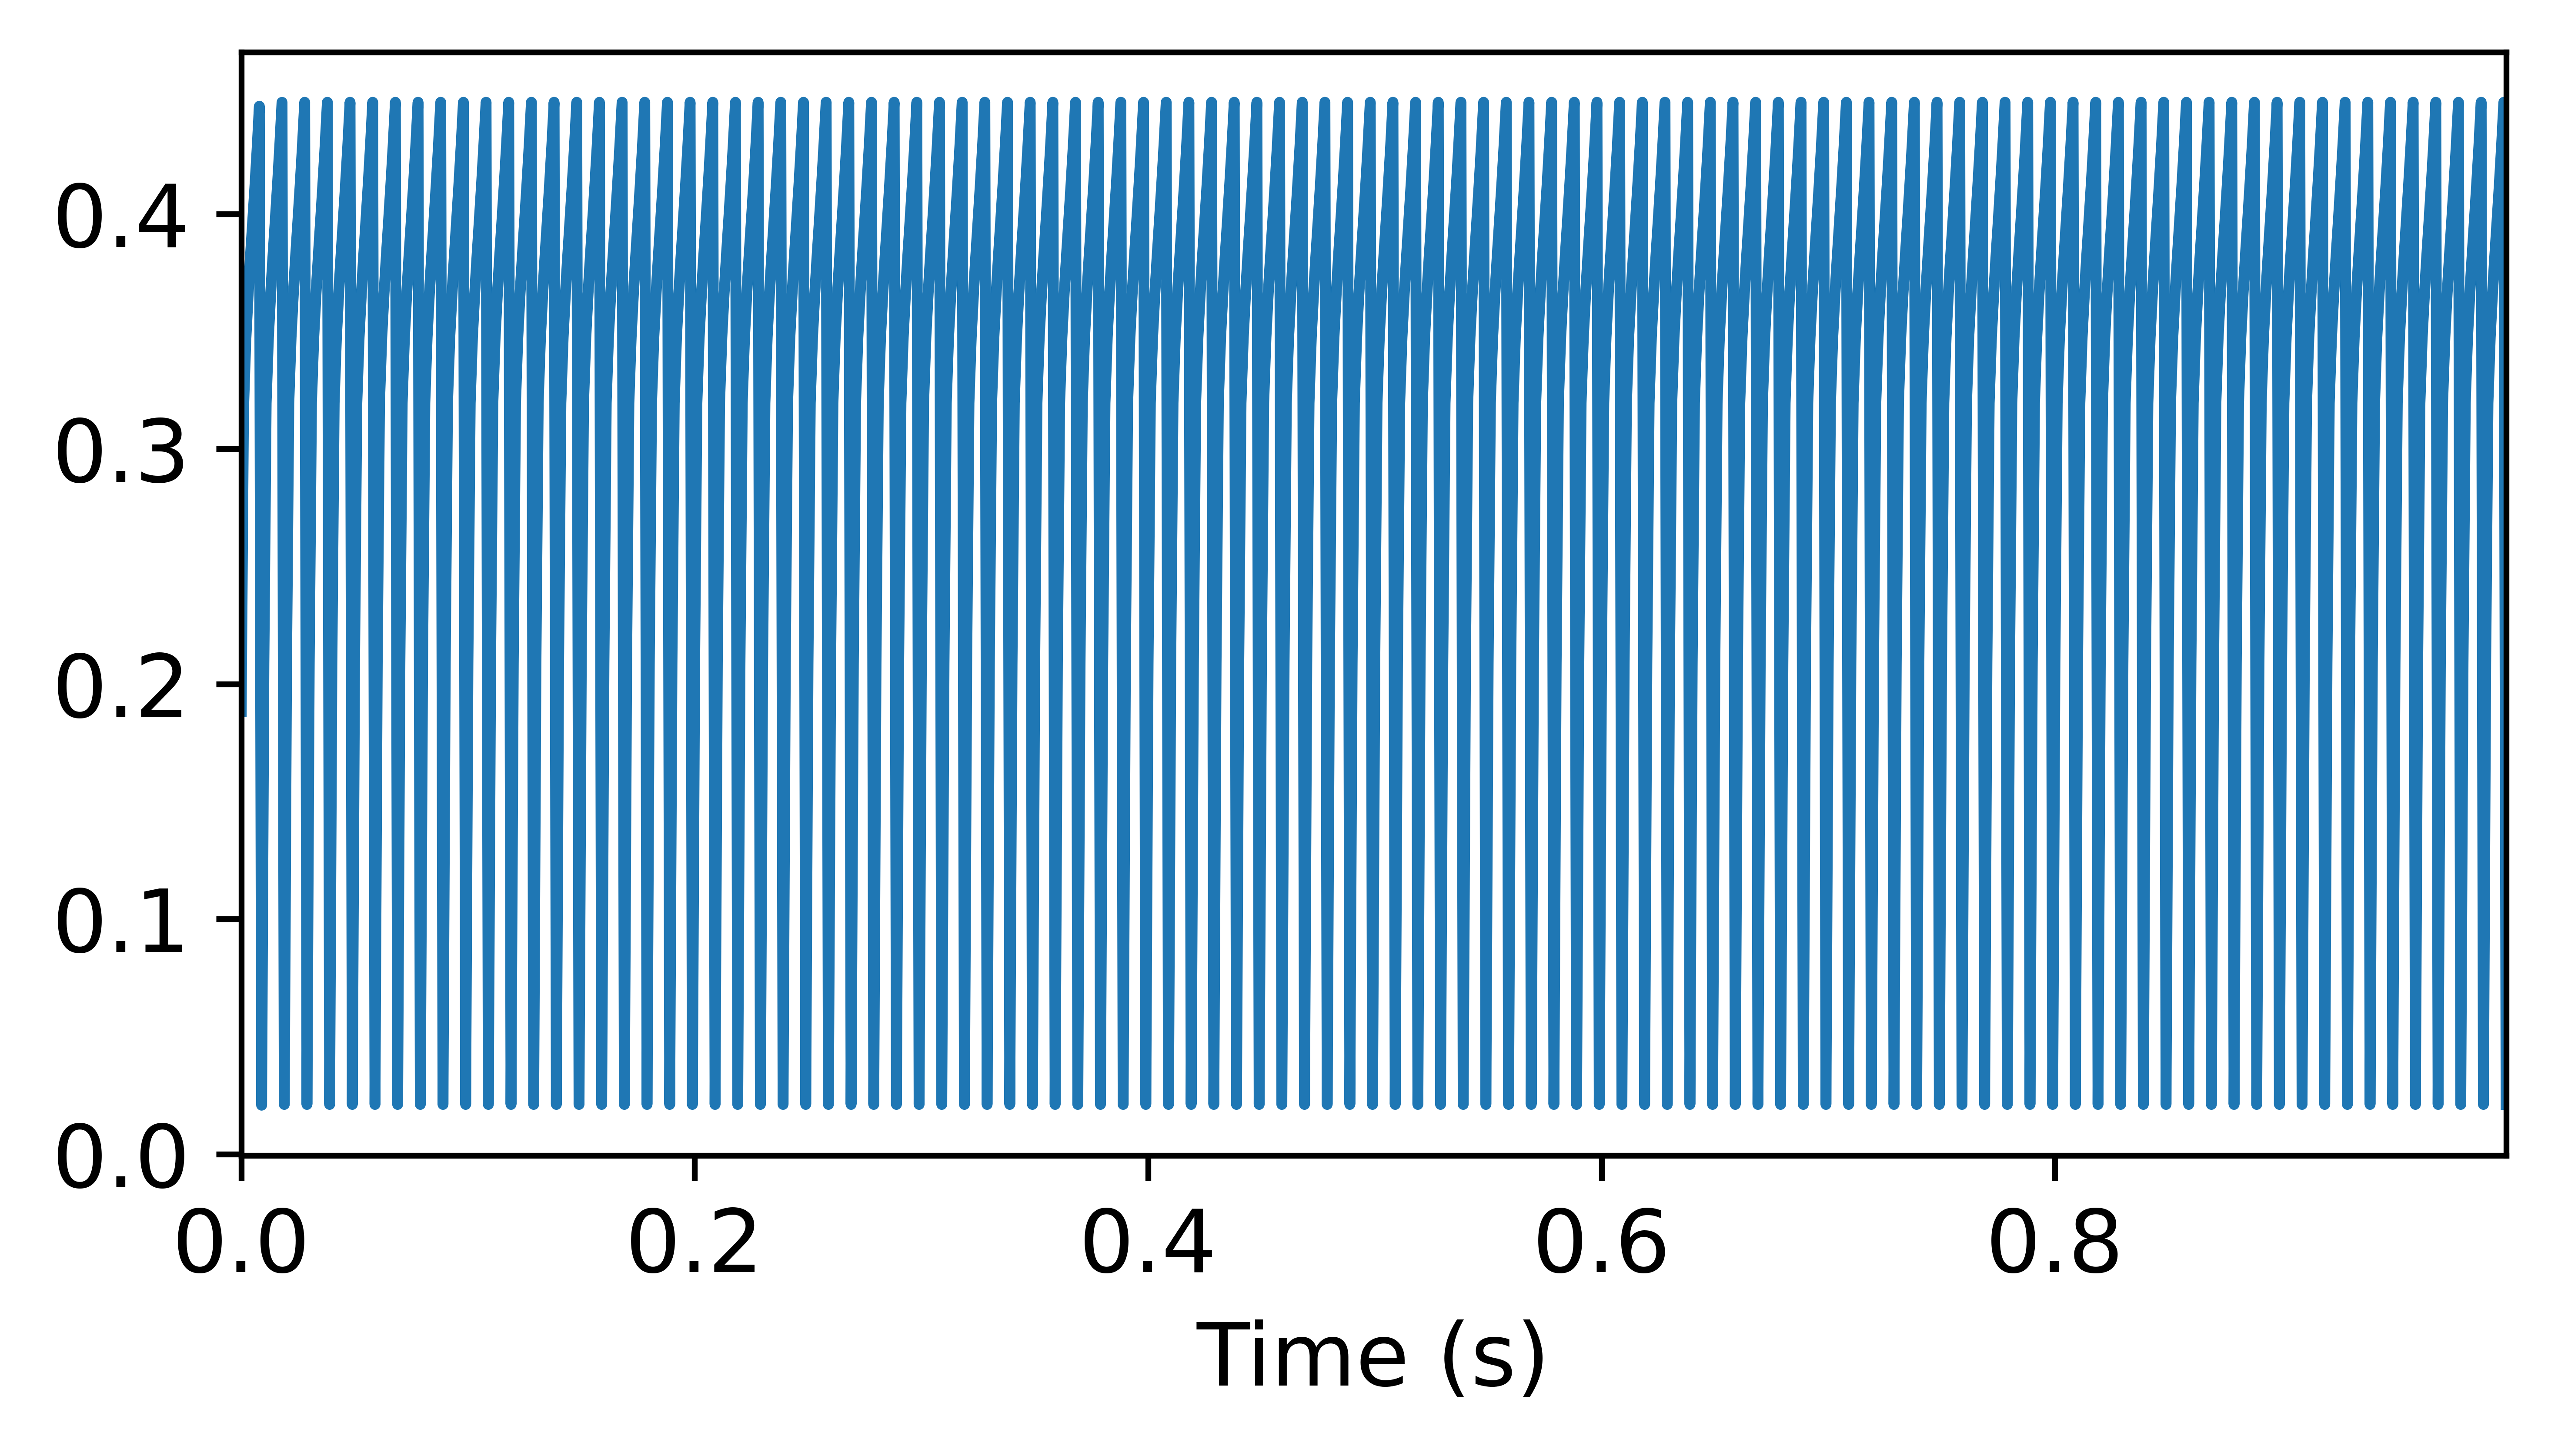

In [5]:
TSContinuous.from_clocked(rec['0_DynapSim']['vmem'][0,:,0], dt=dt).plot()

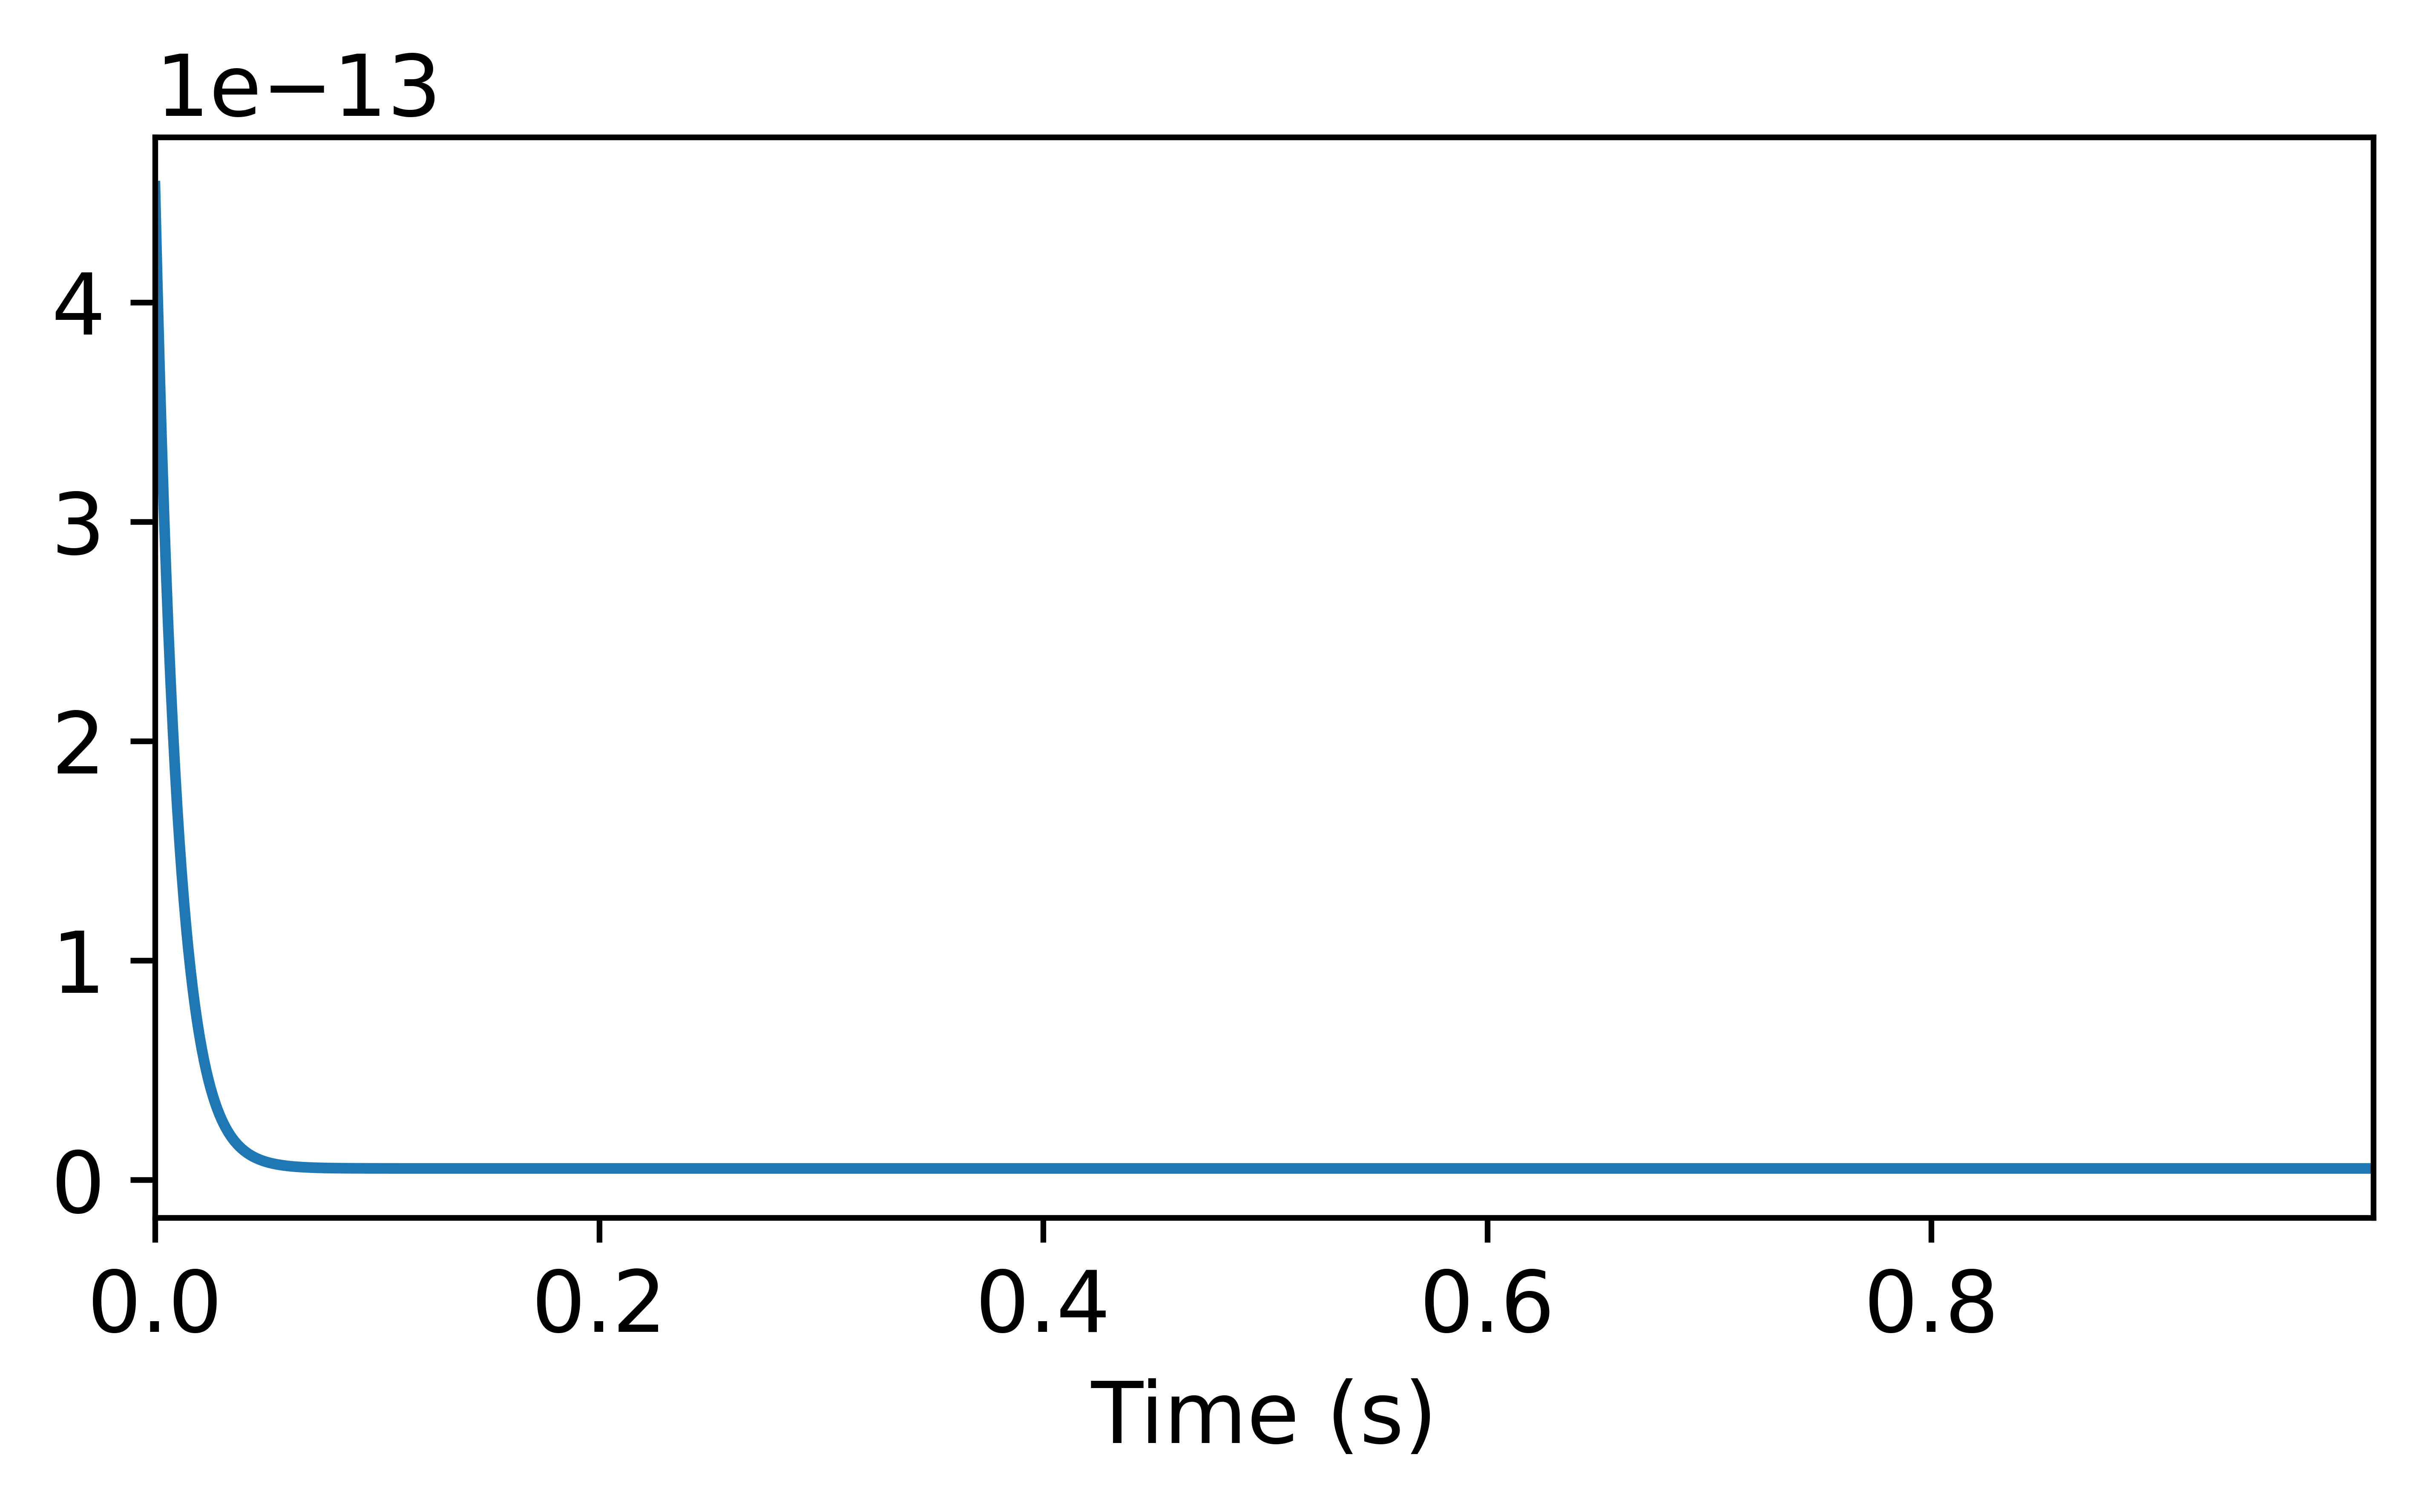

In [6]:
TSContinuous.from_clocked(rec['0_DynapSim']['isyn'][0,:,0], dt=dt).plot()

## Step 4 : Extract the Computational Graph

In [7]:
net.as_graph()

GraphHolder "JaxSequential__4447940384" with 20 input nodes -> 20 output nodes

## Step 5 : Map the Network to a Hardware Specification

In [8]:
spec = mapper(net.as_graph())
spec

{'mapped_graph': GraphHolder "JaxSequential__4447940384" with 20 input nodes -> 20 output nodes,
 'weights_in': None,
 'weights_rec': None,
 'Iscale': [1e-08],
 'n_cluster': 1,
 'core_map': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'n_neuron': 20,
 'unclustered': {'Idc': [1.999999987845058e-08,
   1.999999987845058e-08,
   1.999999987845058e-08,
   1.999999987845058e-08,
   1.999999987845058e-08,
   1.999999987845058e-08,
   1.999999987845058e-08,
   1.999999987845058e-08,
   1.999999987845058e-08,
   1.999999987845058e-08,
   1.999999987845058e-08,
   1.999999987845058e-08,
   1.999999987845058e-08,
   1.999999987845058e-08,
   1.999999987845058e-08,
   1.999999987845058e-08,
   1.999999987845058e-08,
   1.999999987845058e-08,
   1.999999987845058e-08,
   1.999999987845058e-08],
  'Igain_mem': [2.1276595069119608e-11,
   2.1276595069119608e-11,
   2.1276595069119608e-11,
   2.1276595069119608e-11,
   2.1276595069119608e-11,
   2.1276595069119608e-11,
   2.1

## Step 7 : Quantize Parameters

In [9]:
config, input_channel_map = config_from_specification(**spec)

In [10]:
## Connect to device
se2_devices = find_dynapse_boards()

found_se2 = len(se2_devices) > 0

if not found_se2:
    raise IOError('This tutorial requires a connected Dynap-SE2 Stack Board HDK to demonstrate.')
else:
    se2 = DynapseSamna((0,20),se2_devices[0], config, input_channel_map)

In [11]:

plt.rcParams["figure.figsize"] = [5.6, 5.6]


def test_network(sample, sample_name):
    out, state, rec = se2(sample, record=True)

    fig, axes = plt.subplots(2, 1)

    ticks = list(rec["channel_map"].keys())
    labels = [dest.tag for dest in rec["channel_map"].values()]
    print(f"OUT : {np.sum(out)}")

    plt.sca(axes[0])
    TSEvent.from_raster(
        sample, t_start=rec["start_time"], t_stop=rec["stop_time"]+dt, dt=dt
    ).plot()
    plt.title(sample_name)
    plt.xlabel("")

    plt.sca(axes[1])
    TSEvent.from_raster(
        out, t_start=rec["start_time"], t_stop=rec["stop_time"]+dt, dt=dt
    ).plot(color="firebrick")
    plt.title("Device Output")
    plt.yticks(ticks, labels)
    plt.tight_layout()
    print(f"Rate = {np.sum(out)}")

In [12]:
se2.current_timestamp()

0.277481

OUT : 433.0
Rate = 433.0


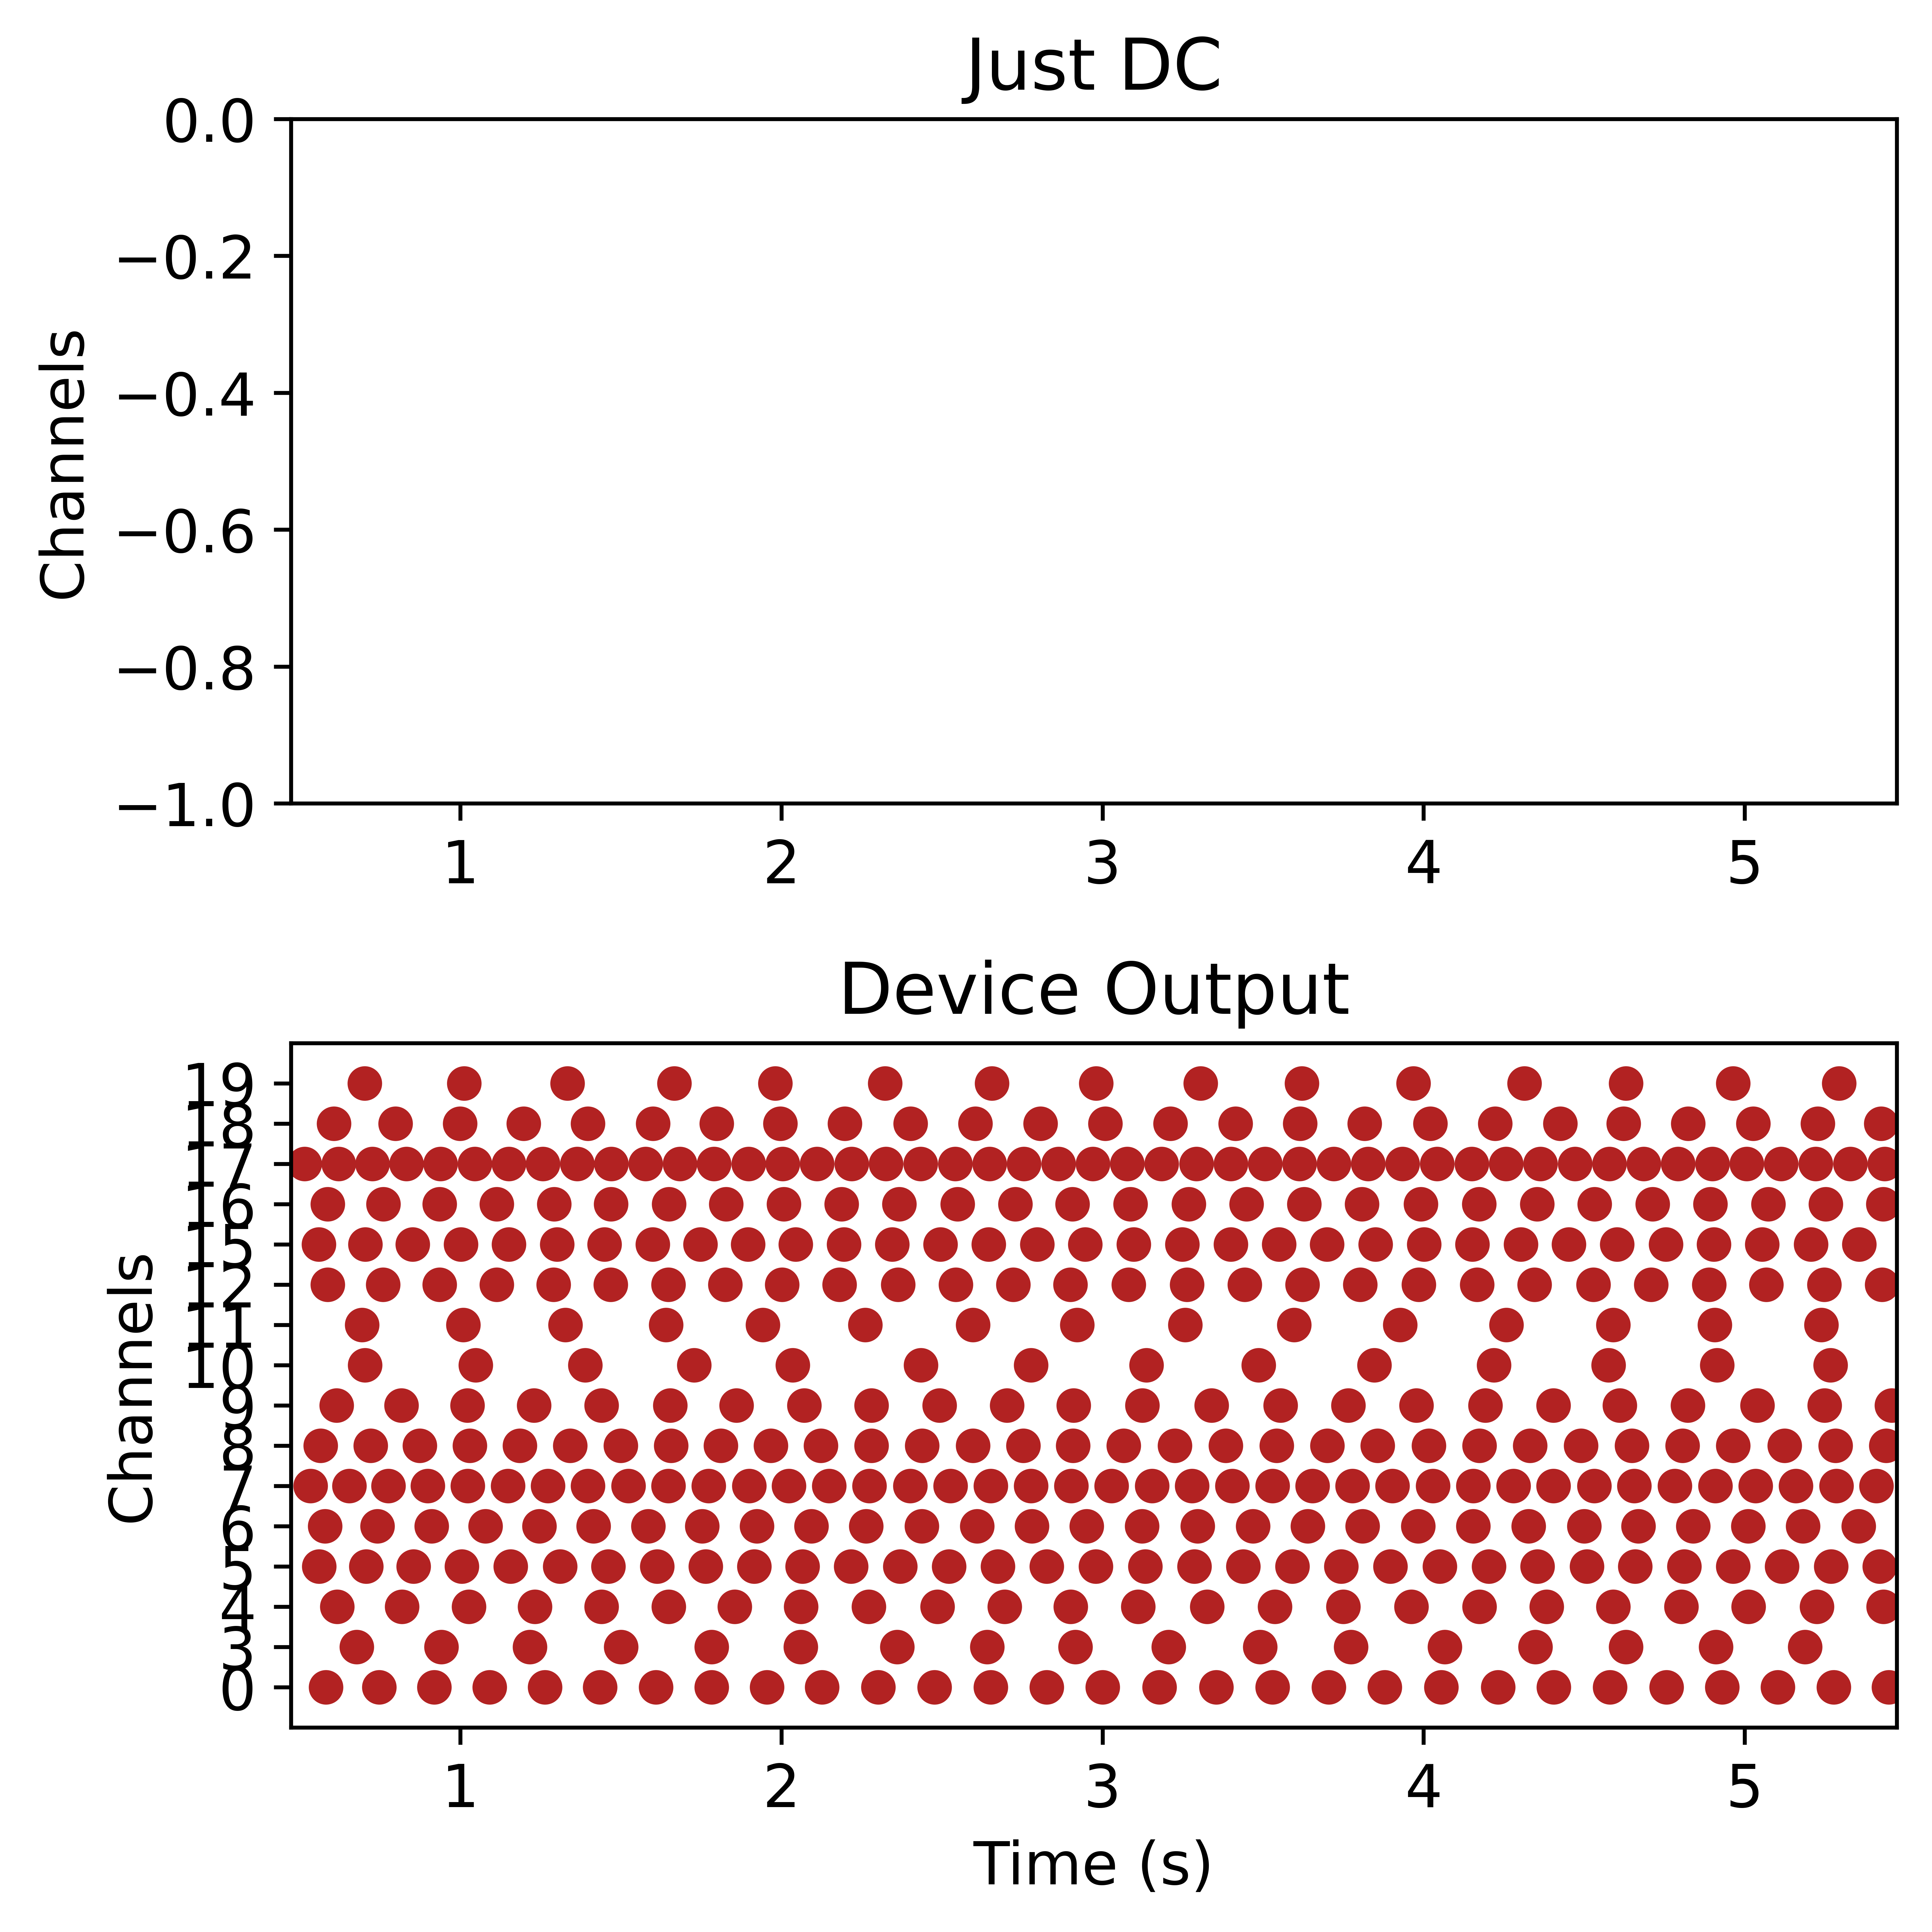

In [13]:
test_network(np.zeros((5000,0)), "Just DC")